<a href="https://colab.research.google.com/github/geraldoferreira1963/Analise_Sentimento/blob/main/Analise_Sentimento_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo do trabalho é utilizando um dataset (https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news) predizer se ação de uma dada empresa - no final de dia de negociação - subirá ou descera (tomando como base o dia anterior).


Este algoritmo, juntamente com outros algoritmos ou metodologias, por exemplo Análise Gráfica, poderiam ser combinados a fim de se criar um ferramenta de suporte a operação de compra e venda de ativos em um único dia na bolsa de valores.


No treinamento do algoritmo foi utilizado o dataset https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news, o qual possui as seguintes colunas :   

(i)     **ticker** : código da ação na Bolsa de Valores de New York
(ii)    **Date** : Data da notícia ou opinião
(iii)   **Category** : se é uma notícia, ou uma opinião de um analista.
(iv)    **title** : título da notícia, ou do artigo
(v)     **content** : conteúdo da notícia, ou do artigo
(vi)    **Open** : valor de abertura da ação
(vii)   **High** : valor de fechamento da ação
(viii)  **Low** : menor valor da ação no dia
(ix)    **Close** : valor de fechamento do preço da ação
(x)     **Adj cloe** : Ajusted Closing Price, ajuste no preço da ação decorrente de algum evento na base acionária da empresa
(xi)    **Volume** : volume de ações negociadas no dia
(xii) **label** : indicação se o preço da ação fechou com um valor maior que o preço **inicial** (1), ou fechou em um valor menor (0)





In [ ]:
# carregando os módulos e bibliotecas

!pip install tensorflow
!pip install gensim
!pip install scikeras
!pip install nltk
!pip install keras-tuner -q # Install keras-tuner

import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import keras_tuner as kt
import tensorflow as tf  # Import tensorflow



from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Attention, Input, Dropout, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model  # Import the Model class
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.layers import TextVectorization

from gensim.models import KeyedVectors  # for Word2Vec

from tensorflow.keras.optimizers import Adam # Import the Adam optimizer

from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping



# Tratamento do Dados
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Carga do Arquivo

In [ ]:
# Corrected URL to download the raw Excel file from GitHub
url = 'https://raw.githubusercontent.com/geraldoferreira1963/Analise_Sentimento/main/carga_inicial_6.xlsx'

response = requests.get(url)

# Save the content to a file with .xlsx extension
with open('carga_inicial_6.xlsx', 'wb') as file:
    file.write(response.content)

# Read the Excel file, explicitly specifying the engine
df = pd.read_excel('carga_inicial_6.xlsx', engine='openpyxl') # Added engine parameter

# Display the first few rows of the DataFrame
df.head()

,Date,category,title,content,label
0,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,0
1,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,0
2,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,0
3,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,0
4,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,0


As funções abaixo foram criadas.

(1) dataframe_analize : objetivo é realizar uma simples
(2) b

In [ ]:
def analyze_dataframe(df):
  """Analyzes a DataFrame and prints statistics about labels, content, and category.

  Args:
    df: The DataFrame to analyze.
  """

  # Count and print label occurrences
  label_counts = df['label'].value_counts()
  print("Number of rows with label 0:", label_counts[0])
  print("Number of rows with label 1:", label_counts[1])

  # Plot label distribution
  label_counts.plot(kind='bar', title='Distribution of Labels')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.show()

  # Calculate and print content length statistics
  df['title_length'] = df['title'].apply(len)
  print("Minimum content length:", df['title_length'].min())
  print("Maximum content length:", df['title_length'].max())

  # Calculate and print the number of unique words
  all_words = ' '.join(df['title']).lower().split()
  unique_words = set(all_words)
  print("Number of unique words:", len(unique_words))

  # Combined category-label plot
  plt.figure(figsize=(12, 6))
  sns.countplot(x='category', hue='label', data=df)
  plt.title('Distribution of Categories by Label')
  plt.xlabel('Category')
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')
  plt.show()



In [ ]:
def create_balanced_dataframe(df, num_instances):
  """Creates a balanced DataFrame with a specified number of instances for each label.

  Args:
    df: The original DataFrame.
    num_instances: The desired number of instances for each label.

  Returns:
    A new DataFrame with balanced labels.
  """

  # Separate instances with label 0 and label 1
  label_0_df = df[df['label'] == 0]
  label_1_df = df[df['label'] == 1]

  # Sample the desired number of instances from each label
  balanced_label_0_df = label_0_df.sample(n=num_instances, random_state=42)  # Use random_state for reproducibility
  balanced_label_1_df = label_1_df.sample(n=num_instances, random_state=42)

  # Concatenate the balanced DataFrames
  balanced_df = pd.concat([balanced_label_0_df, balanced_label_1_df])

  return balanced_df

In [ ]:
def preprocess_text(text, lemmatize=True):
    """Removes stop words, punctuation, and optionally performs lemmatization.

    Args:
        text: The input text string.
        lemmatize: A boolean indicating whether to perform lemmatization.

    Returns:
        The preprocessed text string.
    """

    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize if specified
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
def load_glove_embeddings(vectorizer):
    # !wget http://nlp.stanford.edu/data/glove.6B.zip  # Download GloVe if not present
    # !unzip glove.6B.zip
    path_to_glove_file = "glove.6B.100d.txt"  # Assuming you downloaded and extracted GloVe

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    embedding_dim = len(embeddings_index["the"])

    num_tokens = max_tokens + 2
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for i, word in enumerate(vectorizer.get_vocabulary()):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_column(df, column_name):
    """
    One-hot encodes a specified column in a Pandas DataFrame and adds the
    encoded columns directly to the existing DataFrame.

    Args:
        df: The Pandas DataFrame.
        column_name: The name of the column to encode.

    Returns:
        The modified DataFrame with the one-hot encoded columns added.
    """

    # Create a OneHotEncoder instance
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the specified column
    encoded_data = encoder.fit_transform(df[[column_name]])

    # Create column names for the encoded features
    encoded_columns = encoder.get_feature_names_out([column_name])

    # Add the encoded columns to the DataFrame
    for i, col_name in enumerate(encoded_columns):
        df[col_name] = encoded_data[:, i]  # Assign encoded values to new columns

    return df  # Return the modified DataFrame


Visualização Inicial do Dataset

Number of rows with label 0: 7135
Number of rows with label 1: 8840


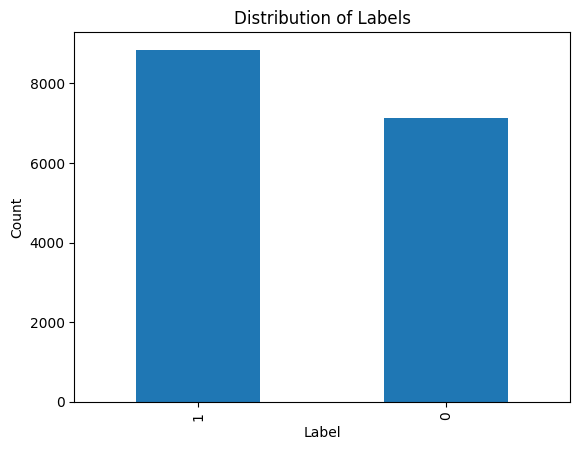

Minimum content length: 10
Maximum content length: 210
Number of unique words: 13150


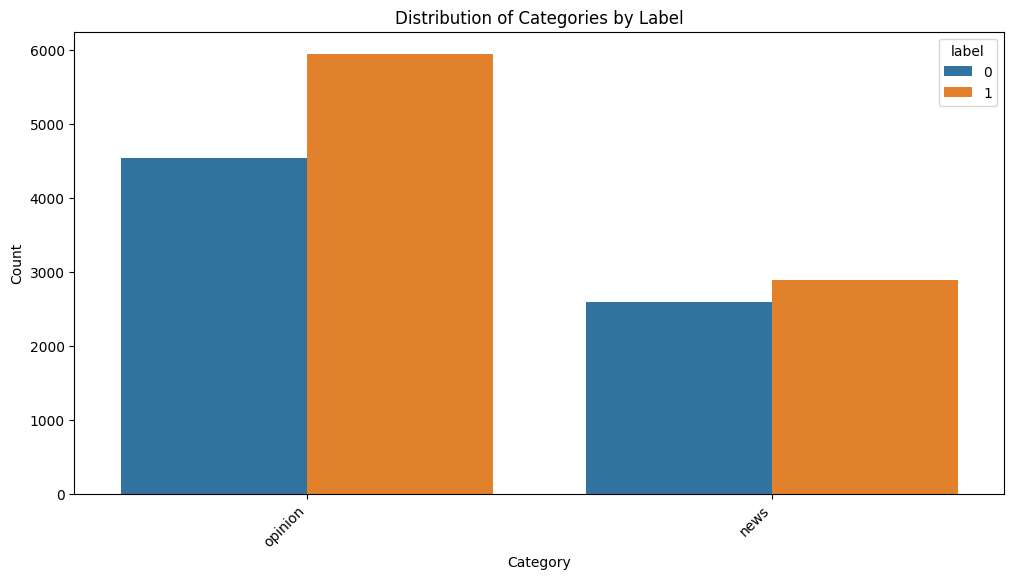

In [ ]:

# Verificação Inicial do dataset
analyze_dataframe(df)  # Call the function to analyze your DataFrame


Ajuste Inicial

Number of rows with label 0: 2000
Number of rows with label 1: 2000


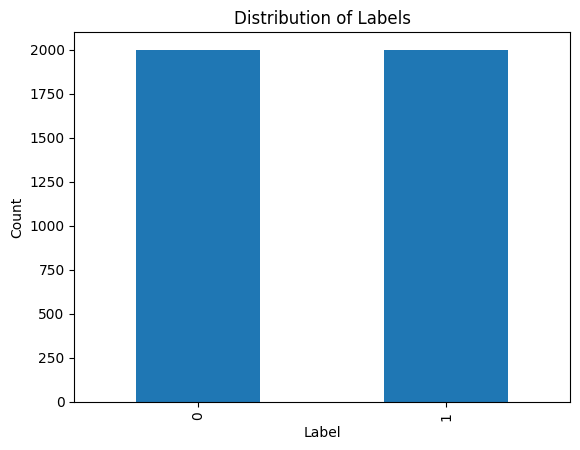

Minimum content length: 12
Maximum content length: 210
Number of unique words: 6680


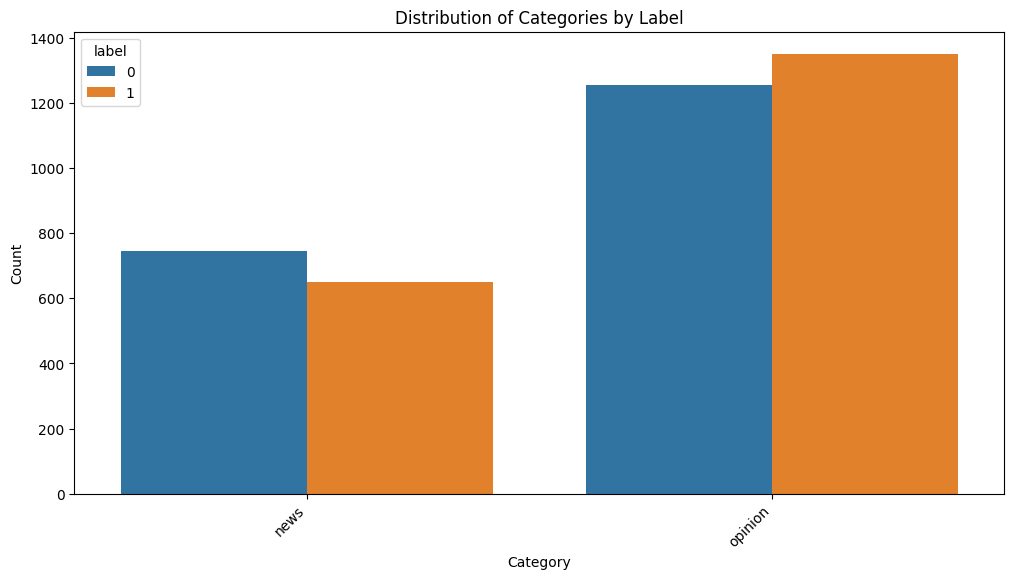

(4000, 6)


In [ ]:
# Example usage:
num_instances_per_label = 2000  # Choose the desired number of instances
balanced_df = create_balanced_dataframe(df, num_instances_per_label)
analyze_dataframe(balanced_df)

# Now you can use balanced_df for further analysis
print(balanced_df.shape)  # Check the shape of the balanced DataFrame

Preparação dos Dados

(1) Coluna News ou Opiniao
(2) Coluna Categoria
(3) Coluna label


In [ ]:
balanced_df.head()

,Date,category,title,content,label,title_length
5460,2018-07-30,news,Day Ahead Top 3 Things to Watch,Investing com Here s a preview of the top 3 ...,0,32
12415,2016-08-22,opinion,Will Pandora P Start On Demand Streaming Ser...,Shares of Pandora Media Inc NYSE P were ...,0,56
785,2019-11-04,opinion,Hill Rom s HRC Q4 Earnings Beat On Strong Gl...,Hill Rom Holdings Inc NYSE HRC reported ...,0,56
1406,2019-09-09,opinion,Chances Of Rate Cut Rise On Jobs Slowdown Win...,Slowdown in the U S private sector job scenar...,0,59
10345,2017-07-09,opinion,Facebook Reveals Plans To Build Willow Campus ...,Facebook Inc NASDAQ FB unveiled plans to...,0,59


In [ ]:
balanced_df['title_length'] = balanced_df['title'].apply(len)
max_length = balanced_df['title_length'].max()  # Adjust maxlen as needed
print(max_length)
all_words = ' '.join(balanced_df['title']).lower().split()
unique_words = set(all_words)
print("Number of unique words:", len(unique_words))

210
Number of unique words: 6680


In [ ]:
!pip install scikit-learn -q # Make sure scikit-learn is installed
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder


# 1. Prepare the data using balanced_df
X_text = balanced_df['title'].values  # Text data
X_cat = balanced_df['category'].values  # Category data
y = balanced_df['label'].values

# Split data into train and test sets

X_text_train, X_text_test, X_train_category, X_test_category, y_train, y_test = train_test_split(
    X_text, X_cat, y, test_size=0.2, random_state=42
)

# 2. Fit and transform the category data
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
X_train_category_encoded = label_encoder.fit_transform(X_train_category)
X_test_category_encoded = label_encoder.transform(X_test_category)

# 3. Reshape the encoded data to have a single column
X_train_category_encoded = X_train_category_encoded.reshape(-1, 1)
X_test_category_encoded = X_test_category_encoded.reshape(-1, 1)


max_tokens = len(unique_words)  # Adjust vocabulary size as needed

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length) # Set output_sequence_length to max_length
vectorizer.adapt(X_text_train)

# Vectorize text data
X_text_train_vec = vectorizer(X_text_train).numpy()
X_text_test_vec = vectorizer(X_text_test).numpy()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

   # Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
     filepath='model_checkpoint_1.keras',  # Path to save the checkpoint file
     monitor='val_accuracy',  # Metric to monitor for saving (e.g., validation accuracy)
     save_best_only=True,  # Save only the best model based on the monitored metric
     save_weights_only=False,  # Save the entire model (architecture and weights)
     mode='max',  # Mode to determine the best model (max for accuracy, min for loss)
     verbose=1 , # Print messages when checkpoints are saved
     save_freq='epoch'
  )

In [ ]:
# 1. Define HyperModel
def build_model(hp):
    # Define Hyperparameters with Ranges
    neurons = hp.Int('neurons', min_value=96, max_value=256, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    dense_neurons = hp.Int('dense_neurons', min_value=96, max_value=128, step=32)
    batch_size = hp.Int('batch_size', min_value=32, max_value=64, step=16)
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=2, step=1)
    lstm_dropout = hp.Float('lstm_dropout', min_value=0.0, max_value=0.6, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)


    # Build the Model (similar to your existing code)
    input_text = Input(shape=(max_length,))  # Now max_length is accessible
    embedding = Embedding(input_dim=max_tokens, output_dim=128)(input_text)

    x = embedding

    for i in range(num_lstm_layers):  # Add LSTM layers dynamically
        # Set return_sequences=True for all but the last LSTM layer
        return_sequences = True if i < num_lstm_layers - 1 else False
        x = Bidirectional(LSTM(neurons,
                                 dropout=lstm_dropout,
                                 recurrent_dropout=recurrent_dropout,
                                 return_sequences=return_sequences))(x)  # Added return_sequences

    text_model = Model(inputs=input_text, outputs=x)


    input_category = Input(shape=(1,))
    combined = concatenate([text_model.output, input_category])
 #  dense = Dense(64, activation='relu')(combined)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)

    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)  # Tune dropout rate
    dropout_output = Dropout(dropout_rate)(dense)  # Apply dropout to the output of the previous Dense layer
    output = Dense(1, activation='sigmoid')(dropout_output)

    model = Model(inputs=[text_model.input, input_category], outputs=output)

    # Conditional optimizer selection
    # Moved the conditional block outside the build_model function
    optimizer_choice = hp.Choice('optimizer', ['adam','sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# 2. Create Tuner
# Removed the extra build_model argument and lambda function
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# 3. Search for Best Hyperparameters
# Define the number of epochs for the search and final training
epochs = 10  # You can adjust this value as needed

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


tuner.search(
    [X_text_train_vec, X_train_category_encoded],
    y_train,
    epochs=epochs,
    validation_data=([X_text_test_vec, X_test_category_encoded], y_test),
    batch_size=32  # Define batch_size here
)

# 4. Get Best Hyperparameters and Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


Reloading Tuner from my_dir/intro_to_kt/tuner0.json

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
160               |128               |neurons
0.00091437        |0.00056912        |learning_rate
128               |96                |dense_neurons
48                |32                |batch_size
1                 |2                 |num_lstm_layers
0                 |0.4               |lstm_dropout
0                 |0.1               |recurrent_dropout
0.5               |0.3               |dropout_rate
sgd               |sgd               |optimizer
20                |7                 |tuner/epochs
7                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |0                 |tuner/round
0021              |None              |tuner/trial_id

Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 616ms/step - accuracy: 0.5072 - loss: 1.7327 - val_accuracy: 0.5250 - val_loss: 1.7295
Epoch 9/20
1

In [ ]:
# 5. Train Best Model
best_model.fit(
    [X_text_train_vec, X_train_category_encoded],
    y_train,
    epochs=epochs,
    validation_data=([X_text_test_vec, X_test_category_encoded], y_test)
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - accuracy: 0.5079 - loss: 0.6975 - val_accuracy: 0.5125 - val_loss: 0.6923
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.6070 - loss: 0.6545 - val_accuracy: 0.5175 - val_loss: 0.7234
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.8521 - loss: 0.3821 - val_accuracy: 0.5300 - val_loss: 1.0011
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.9382 - loss: 0.1561 - val_accuracy: 0.5600 - val_loss: 1.2497
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 320ms/step - accuracy: 0.9891 - loss: 0.0478 - val_accuracy: 0.5450 - val_loss: 1.9612
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.9947 - loss: 0.0242 - val_accuracy: 0.5600 - val_loss: 2.3045
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.9887 - loss: 0.0257 - val_accuracy: 0.5250 - val_loss: 2.3736
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.9956 - loss: 0.0126 - val_accu

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_checkpoint_1.keras')  # Replace with your checkpoint file name if different

ValueError: File not found: filepath=model_checkpoint_1.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from tensorflow.keras.models import load_model
import os

if os.path.exists('model_checkpoint_1.keras'):
    print("Loading existing checkpoint")
    model = load_model('model_checkpoint_1.keras')
else:
    print("No checkpoint found, creating a new model")
    model = build_model(best_hps)  # Or however you create your initial model

# Load the saved model
loaded_model = load_model('model_checkpoint_1.keras')

# Continue training
loaded_model.fit(
    X_text_train_vec,
    y_train_encoded,
    epochs=epochs,
    validation_data=(X_text_test_vec, y_test_encoded),
    callbacks=[early_stopping]  # You might still want to use EarlyStopping
   )

No checkpoint found, creating a new model


NameError: name 'best_hps' is not defined

Modelo

In [ ]:
# 1. Prepare the data
# Assuming you have 'balanced_df' DataFrame
X_text = balanced_df['content'].values  # Text data for content column
X_cat = balanced_df['category'].values  # Category data
y = balanced_df['label'].values  # Label data

# Preprocess text data (if needed)
X_text = [preprocess_text(text) for text in X_text]


# 2. Preprocessing
# a. TextVectorization for content
max_tokens = max_token  # Adjust vocabulary size as needed
max_length = 500  # Adjust sequence length as needed
vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length)
vectorizer.adapt(X_text)
X_text_vec = vectorizer(X_text).numpy()

# b. LabelEncoder for category
label_encoder = LabelEncoder()
X_cat_encoded = label_encoder.fit_transform(X_cat)
X_cat_encoded = X_cat_encoded.reshape(-1, 1)  # Reshape for model input

# 3. Create the encoder
encoder_input = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=max_tokens, output_dim=128)(encoder_input)
conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
encoder_output = Bidirectional(LSTM(units=128))(pooling_layer)  # Bidirectional LSTM
encoder_output = Dropout(0.2)(encoder_output)  # Dropout layer

# 4. Create the decoder
decoder_input = Input(shape=(1,))
decoder_lstm = LSTM(units=128, return_sequences=True)(decoder_input, initial_state=[encoder_output, encoder_output])
decoder_lstm = Dropout(0.2)(decoder_lstm)  # Dropout layer

# 5. Concatenate encoder and decoder outputs
merged_output = concatenate([decoder_lstm, encoder_output])  # Combine decoder and encoder outputs

# 6. Output layer
output = Dense(1, activation='sigmoid')(merged_output)

# 7. Create the model
model_III = Model(inputs=[encoder_input, decoder_input], outputs=output)

# 8. Model summary
model_III.summary()

# 9. Compile the model
model_III.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 10. Train the model
model.fit([X_text_vec, X_cat_encoded], y, epochs=10, batch_size=32, validation_split=0.2)

